# Chapter 7. 토픽 모델링으로 주제 찾기

## 1. 토픽 모델링의 이해

1: https://mobile.newsis.com/view.html?ar_id=NISX20190918_0000772783#_enliple
2: https://cyram.tistory.com/309

### 1.1 LDA(Latent Dirichlet Allocation)



### 1.2 모형의 평가와 적절한 토픽 수의 결정


## 2. 사이킷런을 이용한 토픽 모델링

### 2.1 데이터 준비



In [22]:
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space', 
              'comp.sys.ibm.pc.hardware', 'sci.crypt']

#학습 데이터셋을 가져옴
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)

print('#Train set size:', len(newsgroups_train.data))
print('#Selected categories:', newsgroups_train.target_names)

#Train set size: 3219
#Selected categories: ['alt.atheism', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.crypt', 'sci.space', 'talk.religion.misc']


In [23]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(token_pattern="[\w']{3,}", stop_words='english', 
                     max_features=2000, min_df=5, max_df=0.5)
review_cv = cv.fit_transform(newsgroups_train.data) 

<>:3: DeprecationWarning: invalid escape sequence \w
<>:3: DeprecationWarning: invalid escape sequence \w
C:\Users\PARKSA~1\AppData\Local\Temp/ipykernel_14832/1577350166.py:3: DeprecationWarning: invalid escape sequence \w
  cv = CountVectorizer(token_pattern="[\w']{3,}", stop_words='english',


### 2.2 LDA 토픽 모델링 실행


1: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html <br>
2: Griffiths, Thomas L., and Mark Steyvers. "Finding scientific topics." Proceedings of the National academy of Sciences 101.suppl 1 (2004): 5228-5235.

In [24]:
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
np.set_printoptions(precision=3)

lda = LatentDirichletAllocation(n_components = 10, #추출할 topic의 수
                                max_iter=5, 
                                topic_word_prior=0.1, doc_topic_prior=1.0,
                                learning_method='online', 
                                n_jobs= -1, #사용 processor 수
                                random_state=0)

review_topics = lda.fit_transform(review_cv)
print('#shape of review_topics:', review_topics.shape)
print('#Sample of review_topics:', review_topics[0])

gross_topic_weights = np.mean(review_topics, axis=0)
print('#Sum of topic weights of documents:', gross_topic_weights)

print('#shape of topic word distribution:', lda.components_.shape)

#shape of review_topics: (3219, 10)
#Sample of review_topics: [0.902 0.007 0.028 0.008 0.007 0.008 0.008 0.007 0.007 0.017]
#Sum of topic weights of documents: [0.087 0.083 0.086 0.114 0.116 0.131 0.092 0.072 0.071 0.148]
#shape of topic word distribution: (10, 2000)


In [25]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        #print(", ".join([feature_names[i]+'('+str(topic[i])+')' for i in topic.argsort()[:-n_top_words - 1:-1]]))
        # 위 slicing에서 맨 뒤 -1은 역순을 의미, 역순으로 했을 때 처음부터 n_top_words까지
    print()

print_top_words(lda,cv.get_feature_names(), 10)

Topic #0: com, morality, article, sgi, keith, sandvik, objective, think, moral, don't
Topic #1: image, graphics, file, files, ftp, available, software, data, use, pub
Topic #2: space, nasa, access, launch, earth, orbit, shuttle, digex, lunar, satellite
Topic #3: article, just, com, don't, like, nntp, host, posting, i'm, university
Topic #4: key, clipper, chip, encryption, com, government, law, keys, use, escrow
Topic #5: scsi, com, bit, ibm, thanks, know, bus, university, posting, nntp
Topic #6: gov, nasa, host, nntp, university, posting, distribution, ___, center, world
Topic #7: drive, com, disk, hard, controller, drives, dos, tape, floppy, problem
Topic #8: key, public, faq, message, mail, pgp, group, des, uni, sci
Topic #9: god, people, don't, jesus, just, believe, does, say, think, know



C:\Users\ParkSangun\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### 2.3 최적의 토픽 수 선택하기


n_components: 6, perplexity: 1061.456
n_components: 7, perplexity: 1063.705
n_components: 8, perplexity: 1010.231
n_components: 9, perplexity: 1022.315
n_components: 10, perplexity: 1026.688
n_components: 11, perplexity: 1038.270
n_components: 12, perplexity: 1032.219
n_components: 13, perplexity: 1036.676
n_components: 14, perplexity: 1038.562
n_components: 15, perplexity: 1044.049


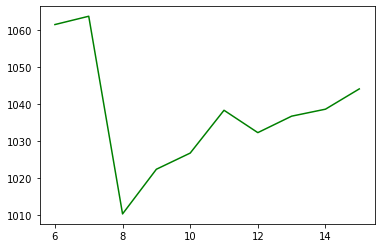

8

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_perplexity(cv, start=10, end=30, max_iter=5, topic_word_prior= 0.1, 
                    doc_topic_prior=1.0):
    iter_num = []
    per_value = []

    for i in range(start, end + 1):
        lda = LatentDirichletAllocation(n_components = i, max_iter=max_iter, 
                                        topic_word_prior= topic_word_prior, 
                                        doc_topic_prior=doc_topic_prior,
                                        learning_method='batch', n_jobs= -1,
                                        random_state=7)    
        lda.fit(cv)
        iter_num.append(i)
        pv = lda.perplexity(cv)
        per_value.append(pv)
        print(f'n_components: {i}, perplexity: {pv:0.3f}')

    plt.plot(iter_num, per_value, 'g-')
    plt.show()
    return start + per_value.index(min(per_value))

show_perplexity(review_cv, start=6, end=15)

In [27]:
lda = LatentDirichletAllocation(n_components = 8, #추출할 topic의 수를 지정
                                max_iter=20, 
                                topic_word_prior= 0.1, 
                                doc_topic_prior=1.0,
                                learning_method='batch',
                                n_jobs= -1, 
                                random_state=7)

review_topics = lda.fit_transform(review_cv)

print_top_words(lda, cv.get_feature_names(), 10)

Topic #0: image, graphics, file, available, mail, ftp, data, information, files, software
Topic #1: posting, nntp, host, com, university, gov, article, distribution, reply, ___
Topic #2: com, keith, morality, article, think, caltech, sgi, don't, objective, moral
Topic #3: com, jesus, article, know, just, don't, god, i'm, good, people
Topic #4: people, god, does, don't, think, say, believe, just, way, like
Topic #5: drive, scsi, card, com, disk, ide, controller, hard, bus, use
Topic #6: space, nasa, access, launch, moon, year, earth, digex, orbit, shuttle
Topic #7: key, encryption, clipper, chip, com, government, keys, use, security, public



## 3. Gensim을 이용한 토픽 모델링


### 3.1 Gensim 사용법과 시각화

1: https://radimrehurek.com/gensim/

In [28]:
#!pip install --upgrade gensim

In [29]:
# 필요한 library들을 import
from nltk.corpus import stopwords
cachedStopWords = stopwords.words("english")

from nltk.tokenize import RegexpTokenizer

RegTok = RegexpTokenizer("[\w']{3,}") # 정규포현식으로 토크나이저를 정의
english_stops = set(stopwords.words('english')) #영어 불용어를 가져옴

def tokenizer(text):
    tokens = RegTok.tokenize(text.lower()) 
    # stopwords 제외
    words = [word for word in tokens if (word not in english_stops) and len(word) > 2]
    return words

texts = [tokenizer(news) for news in newsgroups_train.data]

<>:7: DeprecationWarning: invalid escape sequence \w
<>:7: DeprecationWarning: invalid escape sequence \w
C:\Users\PARKSA~1\AppData\Local\Temp/ipykernel_14832/1454471337.py:7: DeprecationWarning: invalid escape sequence \w
  RegTok = RegexpTokenizer("[\w']{3,}") # 정규포현식으로 토크나이저를 정의


1: https://radimrehurek.com/gensim/corpora/dictionary.html

In [30]:
from gensim.corpora.dictionary import Dictionary

# 토큰화 결과로부터 dictionay 생성
dictionary = Dictionary(texts)
print('#Number of initial unique words in documents:', len(dictionary))

# 문서 빈도수가 너무 적거나 높은 단어를 필터링하고 특성을 단어의 빈도 순으로 선택
dictionary.filter_extremes(keep_n = 2000, no_below=5, no_above=0.5)
print('#Number of unique words after removing rare and common words:', len(dictionary))

# 카운트 벡터로 변환
corpus = [dictionary.doc2bow(text) for text in texts]
print('#Number of unique tokens: %d' % len(dictionary))
print('#Number of documents: %d' % len(corpus))

#Number of initial unique words in documents: 46466
#Number of unique words after removing rare and common words: 2000
#Number of unique tokens: 2000
#Number of documents: 3219


1: https://radimrehurek.com/gensim/models/ldamodel.html 

In [31]:
from gensim.models import LdaModel

num_topics = 10
passes = 5
%time model = LdaModel(corpus=corpus, id2word=dictionary,\
                       passes=passes, num_topics=num_topics, \
                       random_state=7)

Wall time: 16.7 s


In [32]:
model.print_topics(num_words=10)

[(0,
  '0.023*"com" + 0.018*"keith" + 0.016*"caltech" + 0.013*"sgi" + 0.013*"nntp" + 0.013*"posting" + 0.013*"host" + 0.012*"would" + 0.012*"system" + 0.011*"livesey"'),
 (1,
  '0.020*"morality" + 0.018*"objective" + 0.015*"one" + 0.015*"say" + 0.014*"uiuc" + 0.012*"frank" + 0.012*"values" + 0.010*"faq" + 0.010*"article" + 0.008*"cso"'),
 (2,
  '0.026*"com" + 0.025*"access" + 0.025*"posting" + 0.023*"host" + 0.023*"nntp" + 0.017*"digex" + 0.015*"article" + 0.013*"cwru" + 0.013*"___" + 0.013*"net"'),
 (3,
  '0.021*"university" + 0.017*"posting" + 0.015*"host" + 0.015*"nntp" + 0.013*"article" + 0.010*"com" + 0.009*"know" + 0.009*"i\'m" + 0.009*"would" + 0.009*"thanks"'),
 (4,
  '0.032*"com" + 0.015*"would" + 0.011*"article" + 0.010*"one" + 0.010*"get" + 0.009*"people" + 0.009*"ibm" + 0.008*"government" + 0.007*"good" + 0.007*"i\'m"'),
 (5,
  '0.025*"key" + 0.017*"encryption" + 0.014*"clipper" + 0.014*"chip" + 0.009*"keys" + 0.009*"use" + 0.008*"security" + 0.008*"government" + 0.008*"pub

In [33]:
print("#topic distribution of the first document: ", model.get_document_topics(corpus)[0])

#topic distribution of the first document:  [(0, 0.72577083), (8, 0.26994908)]


In [34]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(model, corpus, dictionary)
lda_viz

C:\Users\ParkSangun\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.137200  0.040249       1        1  22.655404
5      0.065989  0.123619       2        1  14.522799
9      0.072133  0.092873       3        1  12.987431
7      0.138320  0.043608       4        1  11.020433
4     -0.021828  0.007494       5        1   9.298375
6      0.072784 -0.094710       6        1   9.118846
3      0.027374 -0.054949       7        1   8.494205
0     -0.040786 -0.129975       8        1   4.524070
2      0.005360 -0.091971       9        1   4.051841
1     -0.182145  0.063760      10        1   3.326596, topic_info=            Term         Freq        Total Category  logprob  loglift
538        space  1487.000000  1487.000000  Default  30.0000  30.0000
20           com  3752.000000  3752.000000  Default  29.0000  29.0000
834          key  1316.000000  1316.000000  Default  28.0000  28.0000
1551        scsi   741.000000   741.000000  Default  27.0000  27.0000
70       posting  1723.000000  1723.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
65        people    64.444375  1672.570952  Topic10  -5.1558   0.1469
789          sci    53.263157   309.473955  Topic10  -5.3463   1.6436
602   university    56.862445  1487.219824  Topic10  -5.2810   0.1392
294         time    55.767081  1187.715350  Topic10  -5.3004   0.3446
315       better    54.192173   564.543537  Topic10  -5.3291   1.0597

[592 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1359      1  0.006274      128
1359      2  0.069013      128
1359      3  0.037643      128
1359      4  0.878342      128
153       1  0.057463     1993
...     ...       ...      ...
343       8  0.022394    years
343       9  0.005599    years
343      10  0.121303    years
704       3  0.991487      zoo
705       3  0.984036  zoology

[2804 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 6, 10, 8, 5, 7, 4, 1, 3, 2])

### 3.2 혼란도와 토픽 응집도를 이용한 최적값 선택

https://radimrehurek.com/gensim/models/coherencemodel.html

In [35]:
from gensim.models import CoherenceModel

cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()
print(coherence)

-1.7493528544065975


num_topics: 6, perplexity: -7.035, coherence: -1.701
num_topics: 7, perplexity: -7.023, coherence: -1.735
num_topics: 8, perplexity: -7.023, coherence: -1.547
num_topics: 9, perplexity: -7.007, coherence: -1.891
num_topics: 10, perplexity: -6.996, coherence: -1.888
num_topics: 11, perplexity: -7.027, coherence: -2.164
num_topics: 12, perplexity: -7.019, coherence: -2.018
num_topics: 13, perplexity: -7.025, coherence: -2.255
num_topics: 14, perplexity: -7.020, coherence: -2.082
num_topics: 15, perplexity: -7.019, coherence: -2.521


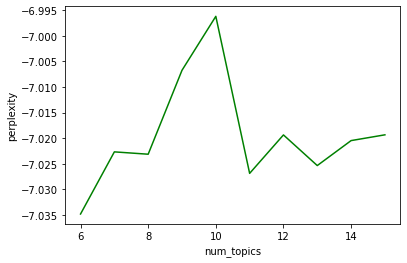

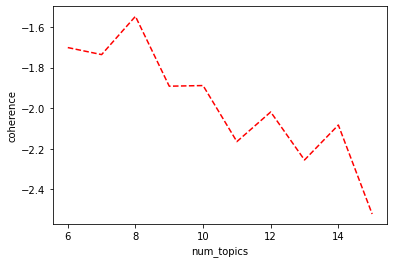

In [36]:
def show_coherence(corpus, dictionary, start=6, end=15):
    iter_num = []
    per_value = []
    coh_value = []

    for i in range(start, end + 1):
        model = LdaModel(corpus=corpus, id2word=dictionary,
                 chunksize=1000, num_topics=i,
                 random_state=7)
        iter_num.append(i)
        pv = model.log_perplexity(corpus)
        per_value.append(pv)
        
        cm = CoherenceModel(model=model, corpus=corpus, 
                            coherence='u_mass')
        cv = cm.get_coherence()
        coh_value.append(cv)
        print(f'num_topics: {i}, perplexity: {pv:0.3f}, coherence: {cv:0.3f}')

    plt.plot(iter_num, per_value, 'g-')
    plt.xlabel("num_topics")
    plt.ylabel("perplexity")
    plt.show()

    plt.plot(iter_num, coh_value, 'r--')
    plt.xlabel("num_topics")
    plt.ylabel("coherence")
    plt.show()

show_coherence(corpus, dictionary, start=6, end=15)

## 4. 토픽트렌드로 시간에 따른 주제의 변화 알아내기

1: https://github.com/akngs/petitions

In [37]:
import pandas as pd

df = pd.read_csv("./data/petition_sampled.csv") #read data
df.head(1)

,0
article_id,58
start,2017-08-19
end,2017-11-17
answered,0
votes,21
category,일자리
title,국토교통부와 한국주택협회가 행한 부당한 행위와 권력남용에 대한 내용을 청원드립니다.
content,안녕하세요? 존경하고 지지하는 문재인 대통령님!\n저는 성남시 분당구 정자동 주택전...


In [38]:
from sklearn.feature_extraction.text import CountVectorizer
from konlpy.tag import Okt #konlpy에서 Twitter 형태소 분석기를 import
twit = Okt()

def tokenizer(doc):
    return [token for token in twit.nouns(doc) if len(token) > 1]

vec = CountVectorizer(tokenizer=tokenizer, #우선은 명사만 사용
                      max_df=0.5, min_df = 5, 
                      max_features = 1000) #적당한 대상 단어 수를 선택

pet_cv = vec.fit_transform(df.content)
print(pet_cv.shape)

(18077, 1000)


In [39]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components = 15, \
                                n_jobs= -1, \
                                random_state=0)

%time pet_topics = lda.fit_transform(pet_cv)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(", ".join([feature_names[i] 
                         for i in topic.argsort()[:-n_top_words - 1:-1]]))
print_top_words(lda,vec.get_feature_names(), 15)

Wall time: 12.3 s
Topic #0: 사람, 생각, 피해자, 병원, 사건, 정말, 가족, 대통령, 자신, 환자, 지금, 가해자, 인간, 국민, 나라
Topic #1: 북한, 한국, 우리, 대통령, 정부, 미국, 대한민국, 일본, 문재인, 국가, 문제, 국민, 생각, 우리나라, 중국
Topic #2: 아이, 부모, 생각, 어린이집, 교사, 엄마, 우리, 유치원, 자녀, 가정, 동물, 저희, 출산, 가족, 아빠
Topic #3: 청소년, 불법, 폐지, 보호, 장애인, 조직, 사찰, 생각, 이용, 외국인, 게임, 노인, 나이, 사회, 사람
Topic #4: 정부, 주택, 정책, 부동산, 서민, 국민, 아파트, 나라, 대통령, 지금, 세금, 사람, 투기, 집값, 임대
Topic #5: 일자리, 기업, 근무, 정부, 생각, 지원, 근로자, 임금, 최저임금, 정책, 시간, 직원, 대기업, 고용, 사람
Topic #6: 국민, 청원, 국회의원, 대통령, 국회, 난민, 의원, 정치, 대한민국, 생각, 나라, 청와대, 반대, 세금, 국가
Topic #7: 대한, 관리, 내용, 조사, 관련, 판결, 업무, 공사, 사실, 판사, 확인, 기관, 해당, 처리, 결과
Topic #8: 학생, 학교, 교육, 선수, 시험, 생각, 대학, 공부, 선생님, 교사, 문제, 시간, 고등학교, 위해, 제도
Topic #9: 보험, 연금, 국민연금, 공무원, 건강, 의료, 지급, 방송, 국민, 소득, 가입, 보험료, 기초, 치료, 제도
Topic #10: 여성, 공무원, 사회, 생각, 남성, 의무, 남자, 대한민국, 여자, 사람, 행정, 군대, 나라, 문제, 국가
Topic #11: 경찰, 범죄, 국민, 사건, 위해, 조직, 대한민국, 불법, 만행, 수사, 경찰서, 범죄자, 부정부패, 검찰, 증거
Topic #12: 처벌, 차량, 사건, 사고, 피해자, 범죄, 경우, 피해, 대한, 기사, 행위, 이명박, 택시, 가해자, 청원
Topic #13: 민원, 화폐, 가상, 정부, 투자, 거래,

C:\Users\ParkSangun\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [40]:
trend_data = pd.DataFrame(pet_topics, columns=['Topic'+str(i) for i in range(1, 16)])
trend_data = pd.concat([trend_data, df.start.map(lambda x: x[:7])], axis=1)
trend_data.iloc[:5, -5:]

,Topic12,Topic13,Topic14,Topic15,start
0,0.000307,0.000307,0.000307,0.000307,2017-08
1,0.000813,0.000813,0.000813,0.425031,2017-08
2,0.001449,0.001449,0.001449,0.001449,2017-08
3,0.000227,0.000227,0.000227,0.000227,2017-08
4,0.000447,0.044870,0.000447,0.000447,2017-08


In [41]:
trend = trend_data.groupby(['start']).mean()
trend.iloc[:5, -5:]

,Topic11,Topic12,Topic13,Topic14,Topic15
start,,,,,
2017-08,0.028187,0.018142,0.023323,0.022292,0.102061
2017-09,0.042437,0.023987,0.097511,0.018154,0.042309
2017-10,0.088276,0.054098,0.064813,0.029914,0.096482
2017-11,0.044859,0.043676,0.229894,0.039596,0.046768
2017-12,0.056061,0.028838,0.074279,0.046931,0.077424


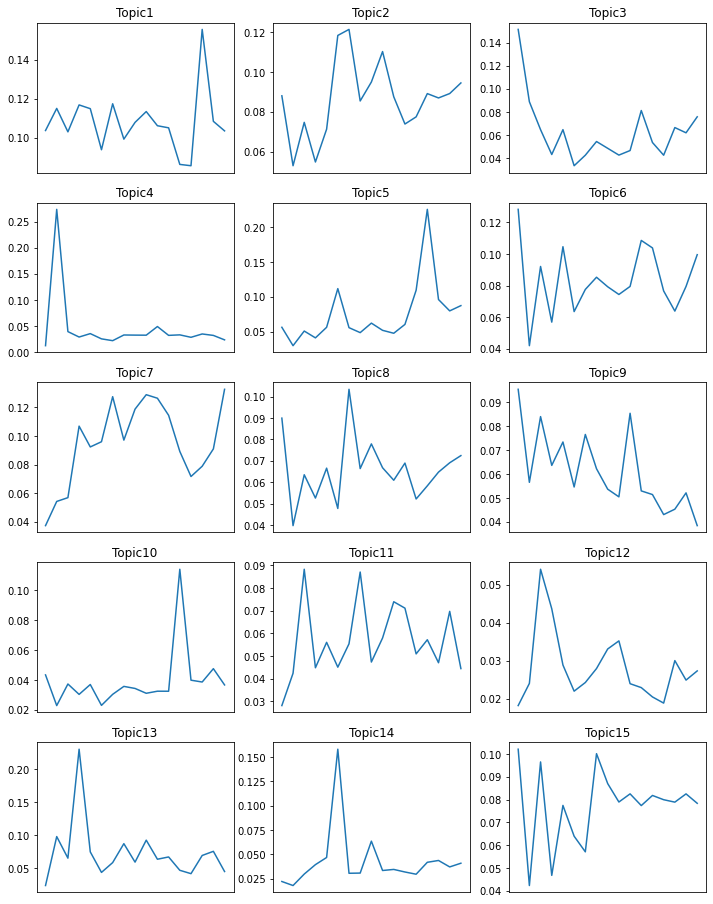

In [42]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(5, 3, sharex='col', figsize=(12, 16)) 
for col, ax in zip(trend.columns.tolist(), axes.ravel()): 
    ax.set_title(col)
    ax.axes.xaxis.set_visible(False)
    ax.plot(trend[col])
plt.show()